So we've previously figured out how to get mid-round win rates in [mid_round_win_rates.ipynb](./mid_round_win_rates.ipynb). For 2 player games, we've also figured out how to get the percentile based on these win rates (since we have roughly normal distributions for win rate values we can use those to calculate percentiles).

For more than 2 players though, it stands to reason that the normal distribution assumption breaks down. For example, in a two player game, the average hand has about a 50% chance of winning at the flop, with most hands having either a slightly higher chance of winning or slightly lower, a few hands will dominate or lose consistently. in other words, the mean and median are both about 50%. In a 3 player game though, there are 2 opposing hands to beat, so the average win rate is 33%. But since it only takes losing to one other player, the median is lower, at 25%. this creates a right skewed distribution which is hard to model with simple parameters like man and standard deviation.

Process here:
1. generate sample data for 3-12 player games, gathering win rates for 1000s of random scenarios.
2. Observe the resulting distributions and research ways to model these skewed distributions using stats.
3. If #2 is unsuccessful, use the samples to calculate percentiles. I.E. for some known win rate and number of players, how many of the sample win rates are better/worse? use that to calculate your percentile.


Note: wound up multithreading this which doesn't work in notebooks, [python file for flop](multithreaded_post_flop_win_rate_example.py), [turn](multithreaded_post_turn_win_rate_example.py), and [river](multithreaded_post_river_win_rate_example.py)

In [2]:
import pandas as pd

three_player_flop_win_rates = pd.read_csv("data/3_player_post_flop_win_rates.csv")

<Axes: >

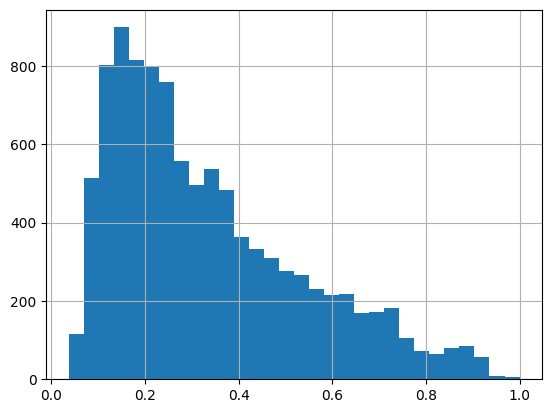

In [3]:
three_player_flop_win_rates['win_rate'].hist(bins=30)

In [4]:
import math

three_player_flop_win_rates['win_rate_sqrt'] = three_player_flop_win_rates['win_rate'].apply(math.sqrt)

<Axes: >

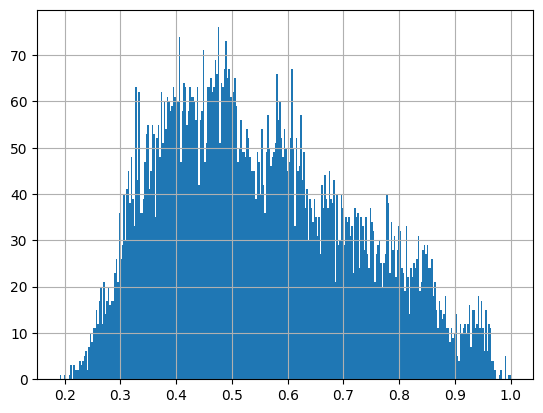

In [7]:
three_player_flop_win_rates['win_rate_sqrt'].hist(bins=300)

Hmm, so the square root doesn't quite get us to a normal distribution, and I can't find anything online that tells me how to get a percentile from distribution stats like skew and kurtosis... I think my best bet here is to sample, but the dataset is pretty big. 13.5MB of CSV files isn't something I want to have to store as part of the library. But I could take a smaller sample, maybe 10k instead of 25k per scenario, and store those, reducing the size to like 5-6MB. I'd feel better about that.

In [11]:
import os

for file in os.listdir("data"):
    if file.endswith("_win_rates.csv"):
        data = pd.read_csv(f"data/{file}")
        data = data.head(10000)
        data[["player_ct", "win_rate"]].to_csv(f"data/{file}", index=False)

In [3]:
#join all the flop, turn, and river csvs into a single df and save it to a memory-sensitive file type
import pandas as pd
import os

# Initialize an empty list to store dataframes
dfs = []

# Loop through player counts and streets
for player_count in range(2, 13):  # 2 to 12 players
    for street in ['flop', 'turn', 'river']:
        file_name = f"data/{player_count}_player_post_{street}_win_rates.csv"
        
        # Check if the file exists before trying to read it
        if os.path.exists(file_name):
            df = pd.read_csv(file_name)
            df['street'] = street
            dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined dataframe as a Parquet file
output_file = "data/combined_win_rates.csv"
combined_df.to_csv(output_file, index=False)

